## Shape experiments - apple data

In this notebook, we compute tangent PCA for the apple dataset. 

In [21]:
# Import packages
import scipy as sp
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import ot
import time
from ot.bregman import sinkhorn
from ot.utils import dist
from ot.optim import cg
import gromovWassersteinAveraging as gwa
from sklearn import manifold
from sklearn.cluster import KMeans
import pandas as pd

import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")


# For easy editing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_dir = os.getcwd() # Get the current working directory name.
mat_fname = pjoin(data_dir, 'planarShapes.mat') 
# Add the file name to the current working directory.

mat_contents = sio.loadmat(mat_fname) # Read the file

planarShapes = mat_contents['planarShapes']
planarShapes.shape

(2, 100, 1300)

In [7]:
# Create labels

labels = list(range(100))

In [79]:
index = 100 #100
shapes = planarShapes[:,:,index:index+20]

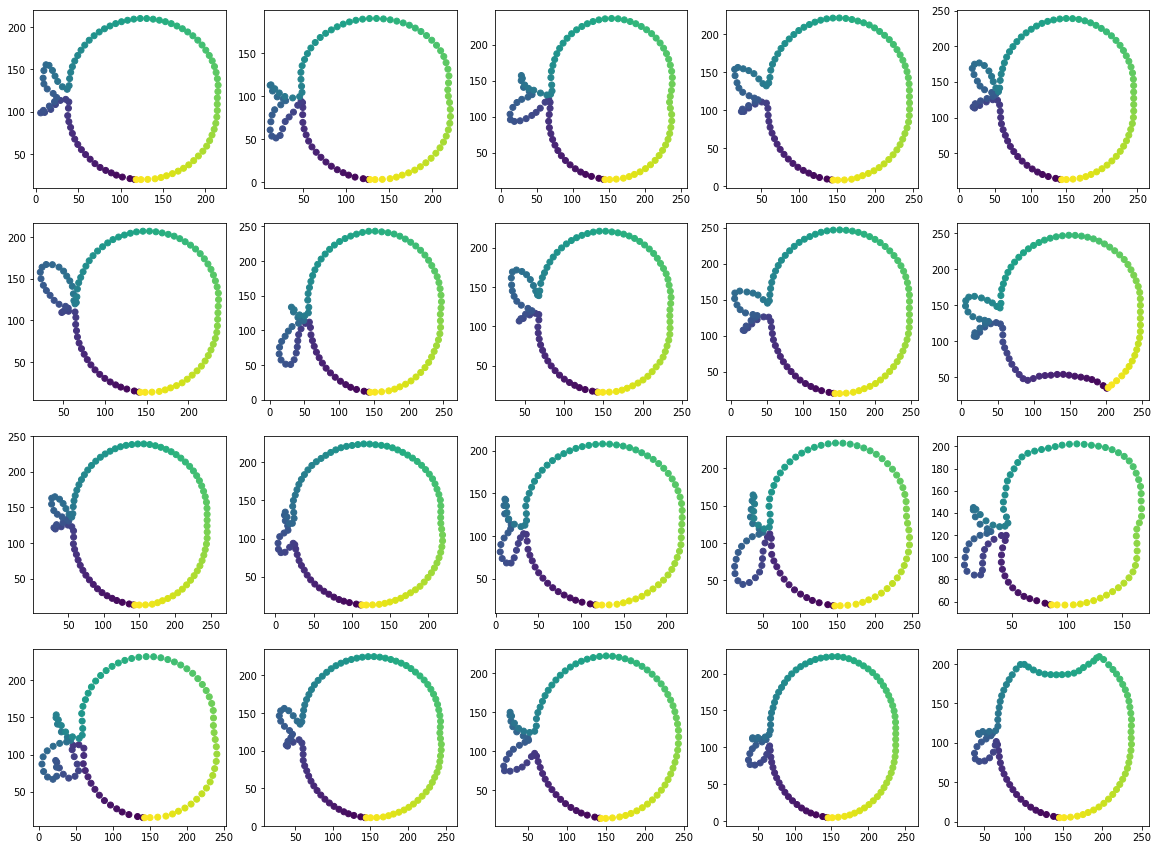

In [98]:
fig = plt.figure(figsize = (20,15))

for j in range(20):
    fig.add_subplot(4,5,j+1)
    plt.scatter(shapes[0, :,j], shapes[1, :,j], c=labels);
    plt.axis('equal');
    

In [81]:
CList = []
pList = []
p = ot.unif(100)

for j in range(20):
    shape = shapes[:,:,j]
    C = sp.spatial.distance.cdist(np.transpose(shape), np.transpose(shape))
    CList.append(C)
    pList.append(p)

In [82]:
start_time = time.time()
CnBase, pnBase, Frechet_Loss = gwa.network_karcher_mean_armijo_sched(CList[0],pList[0],CList,pList,20,50)
print("--- %s seconds ---" % (time.time() - start_time))

Iter Frechet_Loss
0 37498.041626229075
current size  (100, 100)
1 89883.66417110214  full steps
current size  (100, 100)
2 83388.0481714892  full steps
current size  (100, 100)
3 41102.50275660516  full steps
current size  (100, 100)
4 41678.40346911176  full steps
current size  (100, 100)
5 41833.51399288963  full steps
current size  (100, 100)
6 41985.70955637508  full steps
current size  (100, 100)
7 106570.00686878768  full steps
current size  (100, 100)
8 94918.76085698021  full steps
current size  (100, 100)
9 135620.2360452735  full steps
current size  (100, 100)
10 65547.9089216023  full steps
current size  (100, 100)
11 71297.80308032934  full steps
current size  (100, 100)
12 123196.80935596864  full steps
current size  (100, 100)
13 111062.0806703692  full steps
current size  (100, 100)
14 139066.7378605292  full steps
current size  (100, 100)
15 151035.44785276632  full steps
current size  (100, 100)
16 121946.20293912593  full steps
current size  (100, 100)
17 171139.14643

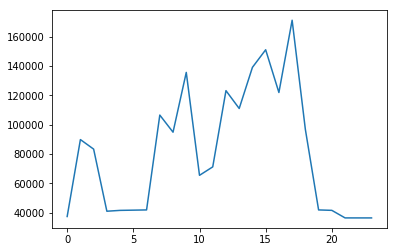

In [83]:
plt.plot(Frechet_Loss)

In [84]:
results = mds.fit(CnBase)
coords = results.embedding_

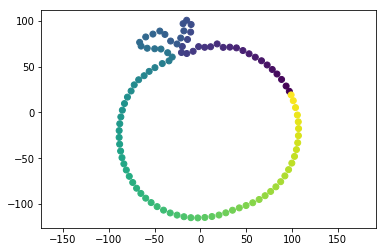

In [85]:
fig = plt.figure()

plt.scatter(coords[:, 0], coords[:, 1], c=labels);
plt.axis('equal');


## PCA step


Note: following the remark in the Shape Experiments notebook, we are using (CnBase, pnBase) here. 

In [86]:
ScheduledAvg = coords

In [87]:
# Set an average to pull back to. I'll use the best (least Frechet loss) example computed above.
avgShape = ScheduledAvg
CAvg = sp.spatial.distance.cdist(avgShape, avgShape)

Pull back each shape to a tangent vector at the average shape.

In [88]:
vectors = np.zeros((20,100*100))

for j in range(20):
    C0, C1, p, q, vec, opt_coup = gwa.log_map(CAvg,CList[j],pList[0],pList[j])
    vec = vec.reshape(1,100*100)
    vectors[j,:] = vec

In [89]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(vectors)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

If we look at the explained variance ratios, we observe that most of the variation is captured by the first two principal directions. Roughly: even though we are in a 10,000 dimensional space, the data lies mainly along a 2-dimensional submanifold.

In [90]:
print(pca.explained_variance_ratio_)

np.sum(pca.explained_variance_ratio_)

[5.99036053e-01 2.10046878e-01 4.95072903e-02 3.21600485e-02
 2.92861916e-02 1.86268074e-02 1.34578771e-02 1.07579878e-02
 7.74457344e-03 6.77506330e-03 4.87539710e-03 3.82537559e-03
 3.01029758e-03 2.71452014e-03 2.36459454e-03 1.94724314e-03
 1.69715904e-03 1.34260442e-03 8.24037222e-04 4.80334978e-33]


0.9999999999999998

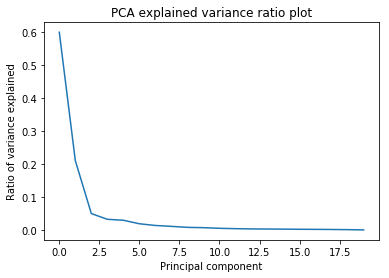

In [91]:
fig = plt.figure()

plt.plot(pca.explained_variance_ratio_)


plt.title('PCA explained variance ratio plot')
plt.xlabel('Principal component')
plt.ylabel('Ratio of variance explained')


We can visualize the main directions of variation as follows.

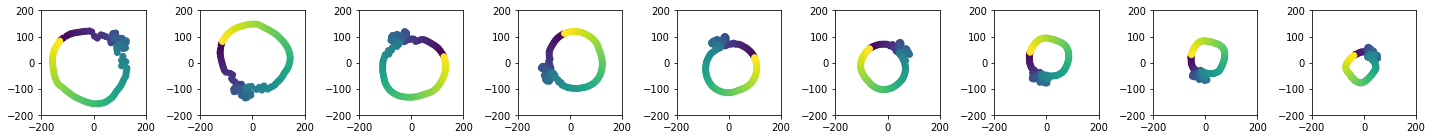

In [112]:
# Center the mean, store first principal vector and singular value
pVec = pca.components_[0].reshape(100,100)
pVal = pca.singular_values_[0]

step_size = 0.3

offset_list = [j*step_size*pVal for j in range(-4,5)]

# Create a list of offsets, proportional to the first singular value.
#offset_list = [-1*pVal, -0.5*pVal, -0.2*pVal, -0.1*pVal, 0*pVal, 0.1*pVal, 0.2*pVal, 0.5*pVal, 1*pVal]

# Create a figure displaying the result of moving the average along the principal direction.
fig = plt.figure(figsize=(20,5))

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=1)

for j in range(len(offset_list)):
    shape = gwa.exp_map(CAvg,offset_list[j]*pVec)
    ax = fig.add_subplot(1,len(offset_list),j+1)
    results = mds.fit(shape)
    coords = results.embedding_
    plt.scatter(coords[:, 0], coords[:, 1], c=labels);
    #plt.axis('equal');
    ax.set_aspect('equal')
    ax.set(xlim=(-200, 200), ylim=(-200, 200))
    
    
fig.tight_layout()

Looking at the second principal direction:

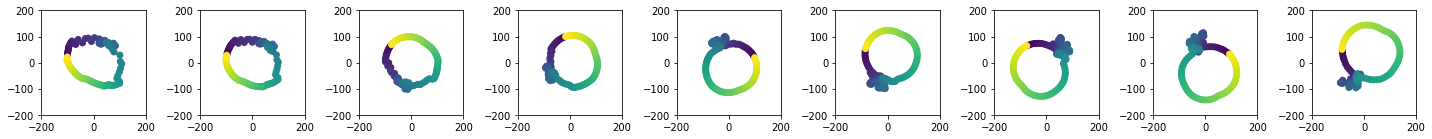

In [114]:
# Center the mean, store first principal vector and singular value
pVec = pca.components_[1].reshape(100,100)
pVal = pca.singular_values_[1]

step_size = 0.3

offset_list = [j*step_size*pVal for j in range(-4,5)]

# Create a figure displaying the result of moving the average along the principal direction.
fig = plt.figure(figsize=(20,5))

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=1)

for j in range(len(offset_list)):
    shape = gwa.exp_map(CAvg,offset_list[j]*pVec)
    ax = fig.add_subplot(1,len(offset_list),j+1)
    results = mds.fit(shape)
    coords = results.embedding_
    plt.scatter(coords[:, 0], coords[:, 1], c=labels);
    #plt.axis('equal');
    #ax.set_aspect('equal', 'box')
    ax.set_aspect('equal')
    ax.set(xlim=(-200, 200), ylim=(-200, 200))
    
fig.tight_layout()

Third principal direction:

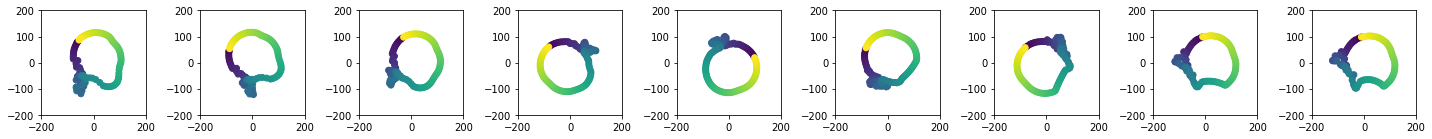

In [116]:
# Center the mean, store first principal vector and singular value
pVec = pca.components_[2].reshape(100,100)
pVal = pca.singular_values_[2]

step_size = 0.3

offset_list = [j*step_size*pVal for j in range(-4,5)]

# Create a figure displaying the result of moving the average along the principal direction.
fig = plt.figure(figsize=(20,5))

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=1)

for j in range(len(offset_list)):
    shape = gwa.exp_map(CAvg,offset_list[j]*pVec)
    ax = fig.add_subplot(1,len(offset_list),j+1)
    results = mds.fit(shape)
    coords = results.embedding_
    plt.scatter(coords[:, 0], coords[:, 1], c=labels);
    #plt.axis('equal');
    #ax.set_aspect('equal', 'box')
    ax.set_aspect('equal')
    ax.set(xlim=(-200, 200), ylim=(-200, 200))
    
fig.tight_layout()